# Differentiating Multidimensional Data

Differential equations often involve multidimensional domains and relationships that rely on derivatives across more than one dimension. Thanks to the linearity of the derivative operator, derivatives can simply be applied along several dimensions in sequence, in any order, where "along a dimension" means applying a differentation method to all vectors running in a given direction/dimension. This can add some bookkeeping, which is why many methods in `numpy` provide an `axis` parameter for ease of handling multidimensional data. Here we demonstrate doing the same with one of our differentiation methods.

In [1]:
import numpy as np
from matplotlib import pyplot
from pynumdiff.finite_difference import finitediff
from pynumdiff.smooth_finite_difference import butterdiff, kerneldiff

methods_and_params = [(finitediff, {}),
						(butterdiff, {'filter_order': 3, 'cutoff_freq': 1 - 1e-6}),
						(kerneldiff, {'kernel': 'gaussian', 'window_size': 5})]

diff_method, params = methods_and_params[1]

In [2]:
T1, T2 = np.meshgrid(np.linspace(-1, 1, 101), np.linspace(-1, 1, 101)) # a 101 x 101 grid
dt = 0.02 # distance between samples in the 2D T grids
x = T1**2 * np.sin(3/2 * np.pi * T2) # 2D function

# d^2 / dt_1 dt_2
analytic_d2 = 3 * T1 * np.pi * np.cos(3/2 * np.pi * T2)
dxdt1 = diff_method(x, dt, **params, axis=0)[1]
computed_d2 = diff_method(dxdt1, dt, **params,axis=1)[1]
print("L2 and Linf errors", np.linalg.norm(analytic_d2 - computed_d2), np.max(np.abs(analytic_d2 - computed_d2)))

# Laplacian
analytic_laplacian = 2 * np.sin(3/2 * np.pi * T2) - 9/4 * np.pi**2 * T1**2 * np.sin(3/2 * np.pi * T2)
dxdt2 = diff_method(x, dt, **params, axis=1)[1]
computed_laplacian = diff_method(dxdt1, dt, **params, axis=0)[1] + diff_method(dxdt2, dt, **params, axis=1)[1]
print("L2 and Linf errors", np.linalg.norm(analytic_laplacian - computed_laplacian), np.max(np.abs(analytic_laplacian - computed_laplacian)))

L2 and Linf errors 0.5783501228244201 0.014036481594047245
L2 and Linf errors 2.1560508403390357 0.0885769016860678


Easy, although because `pynumdiff` is not presently designed to take any derivative beyond 1<sup>st</sup> order, since these tend to get ever more inaccurate in the presence of noise, we have to take derivatives one order at a time.

Now let's see it.

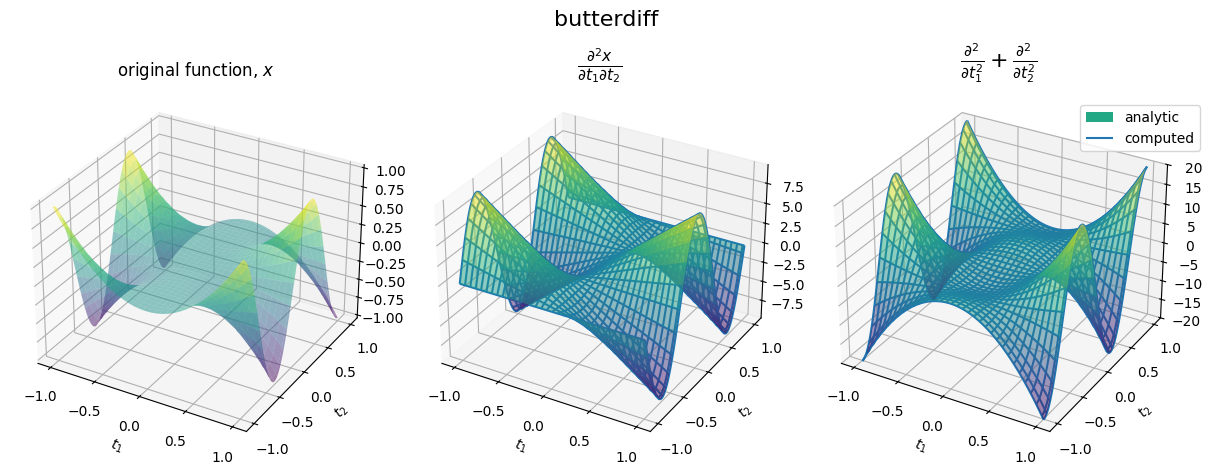

In [3]:
fig = pyplot.figure(figsize=(12, 5), constrained_layout=True)
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.plot_surface(T1, T2, x, cmap='viridis', alpha=0.5)
ax1.set_title(r'original function, $x$')
ax1.set_xlabel(r'$t_1$')
ax1.set_ylabel(r'$t_2$')
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot_surface(T1, T2, analytic_d2, cmap='viridis', alpha=0.5)
ax2.set_title(r'$\frac{\partial^2 x}{\partial t_1 \partial t_2}$', fontsize=16)
ax2.set_xlabel(r'$t_1$')
ax2.set_ylabel(r'$t_2$')
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
surf = ax3.plot_surface(T1, T2, analytic_laplacian, cmap='viridis', alpha=0.5, label='analytic')
ax3.set_title(r'$\frac{\partial^2}{\partial t_1^2} + \frac{\partial^2}{\partial t_2^2}$', fontsize=16)
ax3.set_xlabel(r'$t_1$')
ax3.set_ylabel(r'$t_2$')
ax3.set_zlim(-20, 20)

ax2.plot_wireframe(T1, T2, computed_d2)
ax3.plot_wireframe(T1, T2, computed_laplacian, label='computed')
legend = ax3.legend(bbox_to_anchor=(0.7, 0.8)); legend.legend_handles[0].set_facecolor(pyplot.cm.viridis(0.6))
fig.suptitle(f'{diff_method.__name__}', fontsize=16);